# Creating a machine learning model from the data prep in BigG_AC 

**Two metholodogies will be implemented in the following models, one taking in consideration the model per truck, or one where the model takes into consideration the timestamps**

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [2]:
Diagnostics_5246 = pd.read_csv('data/Diagnostics_5246.csv')
Diagnostics_1569 =  pd.read_csv('data/Diagnostics_1569.csv')

In [3]:
Diagnostics_5246

,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,FuelRate,FuelTemperature,IntakeManifoldTemperature,LampStatus,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,target
0,0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,unknown,unknown,unknown,unknown,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1,2,990360,2015-02-21 11:34:34,NaN,unknown,unknown,unknown,unknown,11,...,25.395354,25.395354,25.395354,25.395354,25.395354,25.395354,25.395354,25.395354,25.395354,0
2,2,4,990370,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,unknown,unknown,unknown,unknown,11,...,39.459260,39.459260,39.459260,39.459260,39.459260,39.459260,39.459260,39.459260,39.459260,0
3,3,6,990431,2015-02-21 11:40:22,Low (Severity Low) Engine Coolant Level,04993120*00025921*082113134117*07700053*I0*BBZ*,79466580,6X1u10D1500000000,CMMNS,0,...,13.602200,13.602200,13.602200,13.602200,13.602200,13.602200,13.602200,13.602200,13.602200,0
4,4,7,990439,2015-02-21 11:40:52,Low (Severity Low) Engine Coolant Level,unknown,unknown,unknown,unknown,0,...,41.534780,41.534780,41.534780,41.534780,41.534780,41.534780,41.534780,41.534780,41.534780,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546659,546659,1248448,123899434,2020-03-06 13:12:43,High Voltage (Fuel Level),NaN,NaN,CECU3B-NAMUX4,PACCR,49,...,0.941766,0.941766,0.941766,0.941766,0.941766,0.941766,0.941766,0.941766,0.941766,0
546660,546660,1248452,123901805,2020-03-06 13:42:48,Low (Severity Medium) Engine Coolant Level,04358814*06030918*051718174436*09401683*G1*BDR*,79904453,6X1u13D1500000000,CMMNS,0,...,5.932153,5.932153,5.932153,5.932153,5.932153,5.932153,5.932153,5.932153,5.932153,0
546661,546661,1248455,123905139,2020-03-06 14:04:23,Condition Exists Engine Protection Torque Derate,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,...,65.010960,65.010960,65.010960,65.010960,65.010960,65.010960,65.010960,65.010960,65.010960,0
546662,546662,1248456,123905996,2020-03-06 14:13:38,Abnormal Rate of Change Aftertreatment 1 Intak...,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,...,66.574100,66.574100,66.574100,66.574100,66.574100,66.574100,66.574100,66.574100,66.574100,0


- Dropping the columns that will not be considered in the model

In [4]:
Diagnostics_5246 = Diagnostics_5246.drop(columns = ['Unnamed: 0', 'ecuSoftwareVersion', 'ecuSerialNumber', 'ecuModel', 'ecuMake',
       'ecuSource', 'eventDescription', 'EventTimeStamp_DateOnly', 'LocationTimeStamp', 'LocationTimeStamp_DateOnly'])
Diagnostics_1569 = Diagnostics_1569.drop(columns = ['Unnamed: 0','ecuSoftwareVersion', 'ecuSerialNumber', 'ecuModel', 'ecuMake',
       'ecuSource'])

Splitting the trucks between derate and non derate. For Diagnostics_5246

In [5]:
all_trucks = Diagnostics_5246['EquipmentID'].unique()
derate_trucks = Diagnostics_5246.loc[Diagnostics_5246['spn'] == 5246]['EquipmentID'].unique()
no_derate_trucks = all_trucks[np.isin(all_trucks, derate_trucks, invert=True)]

- put the two lists together (marking 1 for trucks with derate, 0 with non):

In [6]:
trucks_df = pd.concat([
            pd.DataFrame({'EquipmentID': derate_trucks, 'derate': 1}),
            pd.DataFrame({'EquipmentID': no_derate_trucks, 'derate': 0}) 
            ])

Using trest_train_split and “stratify” to ensure the proportions of derate/non-derate stay same in the samples:


- And then you’d use something like below to extract and train:

In [7]:
def test_split_data_custom(Diagnostics_5246, spn, percentage):
    all_trucks = Diagnostics_5246['EquipmentID'].unique()
    derate_trucks = Diagnostics_5246.loc[Diagnostics_5246['spn'] == spn]['EquipmentID'].unique()
    no_derate_trucks = all_trucks[np.isin(all_trucks, derate_trucks, invert=True)]


    #shuffle(sklearn) the array so that we get ramdom sequence in sample split
    all_Equip_s = shuffle(all_trucks, random_state=42)
    derate_Equip_s = shuffle(derate_trucks, random_state=42)
    no_derate_Equip_s = shuffle(no_derate_trucks, random_state=42)


    print(len(all_Equip_s))
    print(len(derate_Equip_s))
    print(len(no_derate_Equip_s))

    #convert to dataframe to locate rows
    df_all_Equip = pd.DataFrame(all_Equip_s, columns = ['EquipmentID'])
    df_derate_Equip = pd.DataFrame(derate_Equip_s, columns = ['EquipmentID'])
    df_no_derate_Equip = pd.DataFrame(no_derate_Equip_s, columns = ['EquipmentID'])


    #get the equipments % based on the passed percentage
    #keep_rows = int(total_rows * percentage)
    keep_rows_nde = int(len(no_derate_Equip_s) * percentage)
    print(keep_rows_nde)

    #============================================
    #STEP- 4 Get X1 for no_derate_Equip
    #============================================
    df_nde_pct_X1_train = df_no_derate_Equip.iloc[:keep_rows_nde, :]
    print(df_nde_pct_X1_train)

    #get rest of the percentage by doing not isin  lookup
    df_nde_pct_X1_test = df_no_derate_Equip[np.isin(df_no_derate_Equip,df_nde_pct_X1_train, invert=True)]
    print(df_nde_pct_X1_test) 

    #Make sure data is correct by checking we dont have equip id in both dataframes
    should_be_zero_nde= df_nde_pct_X1_train[np.isin(df_nde_pct_X1_train,df_nde_pct_X1_test)]
    print("should_be_zero nde = "  + str(should_be_zero_nde.size)) 

    #============================================
    #STEP 5 get X2 or train and Test
    #============================================
    keep_rows_de = int(len(derate_Equip_s) * percentage)
    print(keep_rows_de)

    df_de_pct_X2_train = df_derate_Equip.iloc[:keep_rows_de, :]
    print(df_de_pct_X2_train)

    #get rest of the percentage by doing not isin  lookup
    df_de_pct_X2_test = df_derate_Equip[np.isin(df_derate_Equip,df_de_pct_X2_train, invert=True)]
    print(df_de_pct_X2_test) 

    #Make sure data is correct by checking we dont have equip id in both dataframes
    should_be_zero_de= df_de_pct_X2_train[np.isin(df_de_pct_X2_train,df_de_pct_X2_test)]
    print("should_be_zero derate = "  + str(should_be_zero_de.size)) 


    # now we have the id ready for trian and test from both derate and no derate data frames. 
    # combine df_nde_pct_X1_train & df_de_pct_X2_train, combine df_nde_pct_X1_test and df_de_pct_X2_test
    combined_df_X_train = pd.concat([df_nde_pct_X1_train, df_de_pct_X2_train], ignore_index=True)
    print(combined_df_X_train)


    # combine df_nde_pct_X1_test & df_de_pct_X2_test, combine df_de_pct_X2_test and df_de_pct_X2_test
    combined_df_X_test = pd.concat([df_nde_pct_X1_test, df_de_pct_X2_test], ignore_index=True)
    print(combined_df_X_test)



    #STEP 6 - Get X_train, y_train and X_test. y_test 
    # Next filter the data from original dataframe for X, y

    df_train = Diagnostics_5246[Diagnostics_5246['EquipmentID'].isin(combined_df_X_train['EquipmentID'].tolist())]
    X_train= df_train.drop(columns=['target'])
    y_train = df_train['target']

    df_test = Diagnostics_5246[Diagnostics_5246['EquipmentID'].isin(combined_df_X_test['EquipmentID'].tolist())]
    X_test =df_test.drop(columns=['target'])
    y_test = df_test['target']

    # x_train, x_test, y_train, y_test

    return X_train, X_test, y_train, y_test

- Spliting the data to train and test to try to get a classifier model 

In [8]:
features = ['AcceleratorPedal', 'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature', 
                'LampStatus', 'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure']
# Create X
X_train = Diagnostics_5246[features]

In [9]:
X_train, X_test, y_train, y_test = test_split_data_custom(Diagnostics_5246, 5246, 0.8)

1039
189
850
680
     EquipmentID
0           2011
1           1843
2           1457
3           2213
4           1427
..           ...
675         2027
676         2112
677         2377
678         2319
679         2247

[680 rows x 1 columns]
     EquipmentID
680         2148
681         2256
682         2128
683         2249
684         2037
..           ...
845         1460
846         1368
847         1583
848         1986
849         1765

[170 rows x 1 columns]
should_be_zero nde = 0
151
     EquipmentID
0           2089
1           1918
2           1490
3           1399
4           1539
..           ...
146         1827
147         1669
148         1591
149         1557
150         1985

[151 rows x 1 columns]
     EquipmentID
151         2143
152         1768
153         1797
154         1401
155         1501
156         1602
157         1582
158         2211
159         1477
160         1384
161         1686
162         1437
163         1604
164         1698
165         1907


In [10]:
X_train = X_train.drop(columns = 'EventTimeStamp')
X_test = X_test.drop(columns = 'EventTimeStamp')

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model
gbm = GradientBoostingClassifier()

In [12]:
# Fit the model to the training data
gbm.fit(X_train, y_train)

GradientBoostingClassifier()

In [13]:
# train a decision tree classifier on the training set
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [14]:
# Predict the labels of the test data
y_pred = gbm.predict(X_test)

In [15]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 99.86%


In [16]:
importances = pd.Series(gbm.feature_importances_, index=X_test.columns)
importances

RecordID                     0.099995
ESS_Id                       0.064723
spn                          0.355434
fmi                          0.069021
active                       0.000000
activeTransitionCount        0.000000
EquipmentID                  0.224101
MCTNumber                    0.001115
Latitude                     0.065698
Longitude                    0.060631
FaultId                      0.043864
AcceleratorPedal             0.000000
BarometricPressure           0.002126
CruiseControlSetSpeed        0.000000
DistanceLtd                  0.000000
EngineCoolantTemperature     0.001905
EngineLoad                   0.000000
EngineOilPressure            0.000039
EngineOilTemperature         0.000116
EngineRpm                    0.001340
EngineTimeLtd                0.001195
FuelLevel                    0.000012
FuelLtd                      0.000091
FuelRate                     0.001155
FuelTemperature              0.000000
IntakeManifoldTemperature    0.002539
LampStatus  

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier()

In [18]:
# make predictions on the testing set
y_pred = classifier.predict(X_test)

In [19]:
# Calculate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    109856
           1       0.10      0.11      0.10       165

    accuracy                           1.00    110021
   macro avg       0.55      0.55      0.55    110021
weighted avg       1.00      1.00      1.00    110021



In [20]:
# evaluate the performance of the classifier using accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9971369102262295


In [21]:
# Get feature importances
importances = classifier.feature_importances_
print(importances)

[0.11022472 0.10724659 0.08980319 0.02035993 0.         0.00521576
 0.1333061  0.00528141 0.16364873 0.13990361 0.11780513 0.00994925
 0.00450151 0.00564115 0.00401369 0.0050708  0.00131868 0.00043211
 0.00674188 0.00197805 0.00043144 0.00606379 0.01081429 0.00815233
 0.00607383 0.00017921 0.00926814 0.00682627 0.0013076  0.00587392
 0.00544038 0.00712651]


In [22]:
# Get feature importances
importances = pd.Series(clf.feature_importances_, index=X_test.columns)
print(importances)

RecordID                     0.122574
ESS_Id                       0.127431
spn                          0.062126
fmi                          0.038879
active                       0.000000
activeTransitionCount        0.011474
EquipmentID                  0.084407
MCTNumber                    0.011737
Latitude                     0.087397
Longitude                    0.088796
FaultId                      0.124918
AcceleratorPedal             0.011453
BarometricPressure           0.011267
CruiseControlSetSpeed        0.011544
DistanceLtd                  0.011754
EngineCoolantTemperature     0.010933
EngineLoad                   0.010571
EngineOilPressure            0.010576
EngineOilTemperature         0.011865
EngineRpm                    0.011029
EngineTimeLtd                0.011557
FuelLevel                    0.011245
FuelLtd                      0.011425
FuelRate                     0.011795
FuelTemperature              0.011700
IntakeManifoldTemperature    0.011808
LampStatus  

In [23]:
importances_sorted = importances.sort_values(ascending=False)

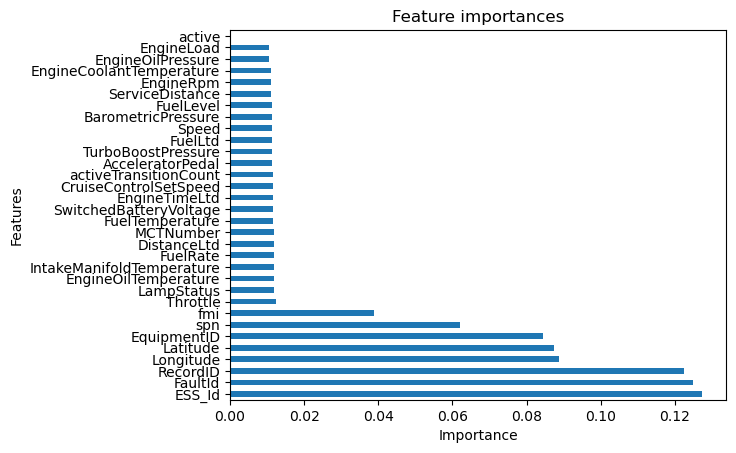

In [24]:
plt.figure()
importances_sorted.plot(kind='barh')
plt.title('Feature importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [25]:
from sklearn import tree
from sklearn.tree import plot_tree

text_representation = tree.export_text(classifier)
print(text_representation)

|--- feature_2 <= 1528.00
|   |--- feature_6 <= 1328.50
|   |   |--- feature_2 <= 77.50
|   |   |   |--- feature_2 <= 37.00
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  37.00
|   |   |   |   |--- feature_9 <= -85.71
|   |   |   |   |   |--- feature_12 <= 23.25
|   |   |   |   |   |   |--- feature_1 <= 60308694.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_1 >  60308694.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_12 >  23.25
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_9 >  -85.71
|   |   |   |   |   |--- class: 1
|   |   |--- feature_2 >  77.50
|   |   |   |--- feature_6 <= 1327.50
|   |   |   |   |--- feature_1 <= 62809252.00
|   |   |   |   |   |--- feature_16 <= 63.39
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_16 >  63.39
|   |   |   |   |   |   |--- feature_14 <= 63.46
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_14

In [26]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[109688    168]
 [   147     18]]


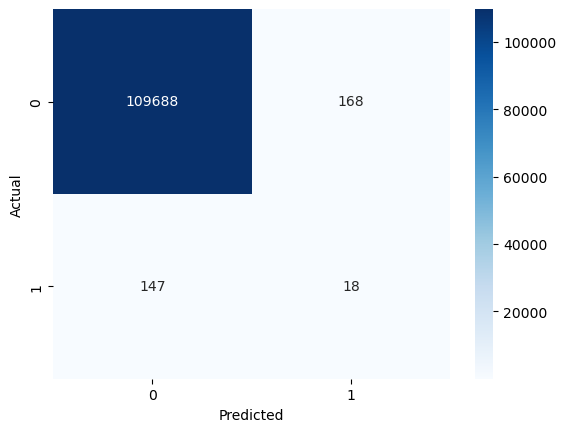

In [27]:
# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

- Tring to improve the model with different classifier.

In [28]:
pipe = Pipeline(
    steps = [
        ('scaler', MinMaxScaler()),
        ('nn', MLPClassifier(hidden_layer_sizes = (2,),
                             activation = 'tanh',
                             max_iter = 10000))
    ]
)

In [29]:
pipe.fit(X_train, y_train) 


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('nn',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(2,),
                               max_iter=10000))])

In [30]:
accuracy_2 = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_2)

Accuracy: 0.9971369102262295


In [31]:
from imblearn.over_sampling import SMOTE

oversampler = SMOTE(k_neighbors=5, random_state=321)

In [32]:
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)

In [33]:
y_smote.value_counts()

0    435856
1    435856
Name: target, dtype: int64

In [34]:
lr = LogisticRegression()
lr.fit(X_smote, y_smote)

LogisticRegression()

In [35]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.6185182828732696

In [36]:
coefficients = lr.coef_

feature_names = X_test.columns

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[0]})
coefficients_df

,Feature,Coefficient
0,RecordID,-9.033828e-08
1,ESS_Id,6.349220e-09
2,spn,1.130594e-09
3,fmi,2.347939e-11
4,active,-4.645614e-13
5,activeTransitionCount,3.567806e-12
6,EquipmentID,-1.588539e-09
7,MCTNumber,3.567806e-12
8,Latitude,-1.539676e-11
9,Longitude,3.846698e-11


In [37]:
cm = confusion_matrix(y_test, y_pred)

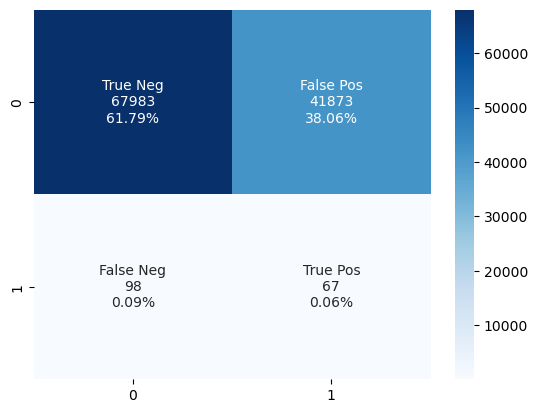

In [38]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues');


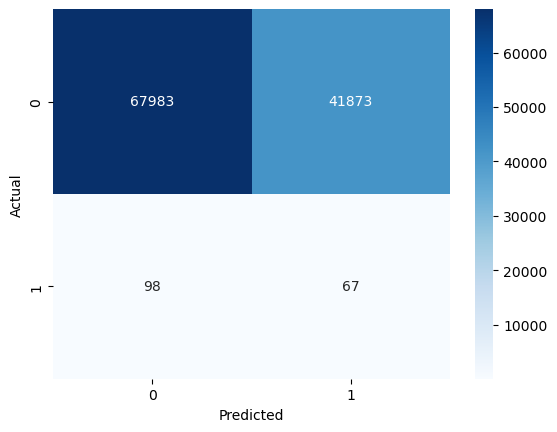

In [39]:
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.62      0.76    109856
           1       0.00      0.41      0.00       165

    accuracy                           0.62    110021
   macro avg       0.50      0.51      0.38    110021
weighted avg       1.00      0.62      0.76    110021



In [41]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 99.85%
